In [40]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    """
    Unzips a zip file to a specified directory

    Args:
        zip_path (str): Path to the zip file
        extract_to (str): Directory where contents will be extracted
    """
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    # Open the zip file in read mode
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all contents to the target directory
        zip_ref.extractall(extract_to)

    print(f"Successfully extracted {zip_path} to {extract_to}")

# Example usage:
zip_file = '/content/hymenoptera_data.zip'  # Path to your zip file
destination = '/content/hymenoptera_data'  # Directory to extract to
unzip_file(zip_file, destination)

Successfully extracted /content/hymenoptera_data.zip to /content/hymenoptera_data


Using device: cpu
Class names: ['ants', 'bees']
Train dataset size: 244
Validation dataset size: 153


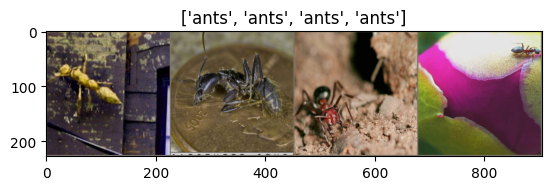

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset with the correct structure
data_dir = '/content/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x])
              for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")

# Visualize a few images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [43]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
feature_extractor = torch.nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4,
    model.avgpool
)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(
    *(list(model.children())[:-3])  # Try -2, -3, -4 etc.
)

# Verify the architecture
print(feature_extractor)

# Check if layers are frozen
for name, param in feature_extractor.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_feature_similarity(feature_extractor, dataloader, device, num_samples=100):
    """
    Calculate average feature similarity within the same class
    """
    feature_extractor.eval()
    features_dict = {'ants': [], 'bees': []}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i >= num_samples:  # Limit number of samples for efficiency
                break

            inputs = inputs.to(device)
            features = feature_extractor(inputs)

            # Properly handle feature dimensions
            if features.dim() == 4:  # [batch, channels, height, width]
                # Global average pooling if spatial dimensions exist
                features = torch.mean(features, dim=[2, 3])  # becomes [batch, channels]
            elif features.dim() == 3:  # [batch, channels, length]
                features = torch.mean(features, dim=2)  # becomes [batch, channels]

            features = features.squeeze()  # Remove any extra dimensions

            # Store features by class
            for j in range(features.shape[0]):
                class_name = class_names[labels[j]]
                features_dict[class_name].append(features[j].cpu().numpy())

    # Calculate intra-class similarity
    similarities = []
    for class_name in features_dict:
        class_features = np.array(features_dict[class_name])
        if len(class_features) > 1:
            # Ensure features are 2D [n_samples, n_features]
            if class_features.ndim > 2:
                class_features = class_features.reshape(class_features.shape[0], -1)
            sim_matrix = cosine_similarity(class_features)
            # Get upper triangular without diagonal
            triu_indices = np.triu_indices(sim_matrix.shape[0], k=1)
            similarities.extend(sim_matrix[triu_indices])

    avg_similarity = np.mean(similarities) if similarities else 0
    return avg_similarity

# Calculate similarity
similarity_score = calculate_feature_similarity(feature_extractor, dataloaders['train'], device)
print(f"Average intra-class feature similarity: {similarity_score:.3f}")

Average intra-class feature similarity: 0.845


In [45]:
def calculate_similarity_metrics(feature_extractor, dataloader, device):
    """
    Calculate intra-class and inter-class feature similarities
    """
    feature_extractor.eval()
    class_features = {'ants': [], 'bees': []}

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)

            # Properly handle feature dimensions
            if features.dim() == 4:  # [batch, channels, height, width]
                # Global average pooling if spatial dimensions exist
                features = torch.mean(features, dim=[2, 3])  # becomes [batch, channels]
            features = features.squeeze()  # Remove any extra dimensions

            # Handle case where batch size is 1
            if features.dim() == 1:
                features = features.unsqueeze(0)

            features = features.cpu().numpy()

            for i in range(len(labels)):
                class_name = class_names[labels[i]]
                class_features[class_name].append(features[i])

    # Convert to numpy arrays with proper shape checking
    def safe_array_conversion(feature_list):
        if not feature_list:
            return np.array([])
        # Convert all features to 2D if needed
        return np.vstack([f.reshape(1, -1) if f.ndim == 1 else f for f in feature_list])

    ants_features = safe_array_conversion(class_features['ants'])
    bees_features = safe_array_conversion(class_features['bees'])

    # Calculate metrics
    metrics = {
        'intra_class_ants': 0,
        'intra_class_bees': 0,
        'inter_class': 0,
        'overall_intra_class': 0
    }

    # Calculate intra-class similarity for ants
    if len(ants_features) > 1:
        ants_sim = cosine_similarity(ants_features)
        metrics['intra_class_ants'] = ants_sim[np.triu_indices(ants_sim.shape[0], k=1)].mean()

    # Calculate intra-class similarity for bees
    if len(bees_features) > 1:
        bees_sim = cosine_similarity(bees_features)
        metrics['intra_class_bees'] = bees_sim[np.triu_indices(bees_sim.shape[0], k=1)].mean()

    # Calculate inter-class similarity
    if len(ants_features) > 0 and len(bees_features) > 0:
        inter_sim = cosine_similarity(ants_features, bees_features)
        metrics['inter_class'] = inter_sim.mean()

    # Calculate overall intra-class similarity
    if (metrics['intra_class_ants'] + metrics['intra_class_bees']) > 0:
        metrics['overall_intra_class'] = (metrics['intra_class_ants'] + metrics['intra_class_bees']) / 2

    return metrics

# Calculate metrics with the fixed function
similarity_metrics = calculate_similarity_metrics(feature_extractor, dataloaders['val'], device)



In [46]:
# Print results
print("\nFeature Similarity Metrics:")
print(f"Intra-class similarity (ants): {similarity_metrics['intra_class_ants']:.3f}")
print(f"Intra-class similarity (bees): {similarity_metrics['intra_class_bees']:.3f}")
print(f"Inter-class similarity: {similarity_metrics['inter_class']:.3f}")
print(f"Overall intra-class similarity: {similarity_metrics['overall_intra_class']:.3f}")


Feature Similarity Metrics:
Intra-class similarity (ants): 0.839
Intra-class similarity (bees): 0.858
Inter-class similarity: 0.833
Overall intra-class similarity: 0.848


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-3975563382.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


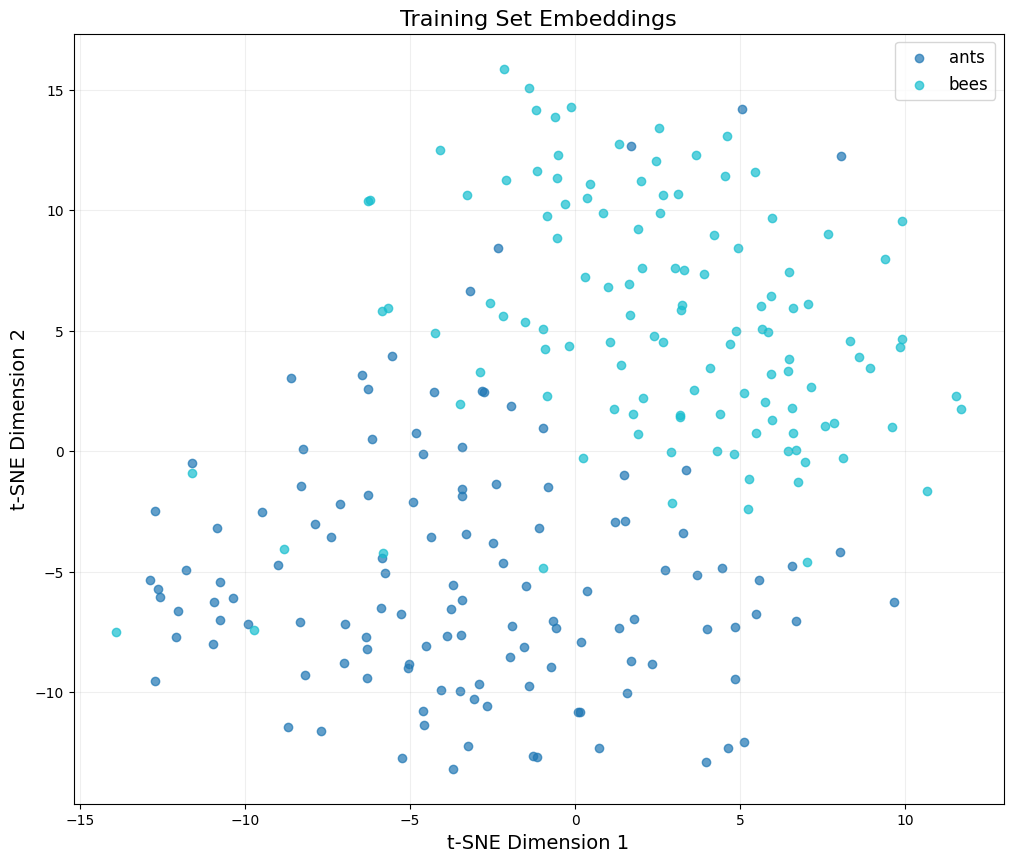

/tmp/ipython-input-3975563382.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


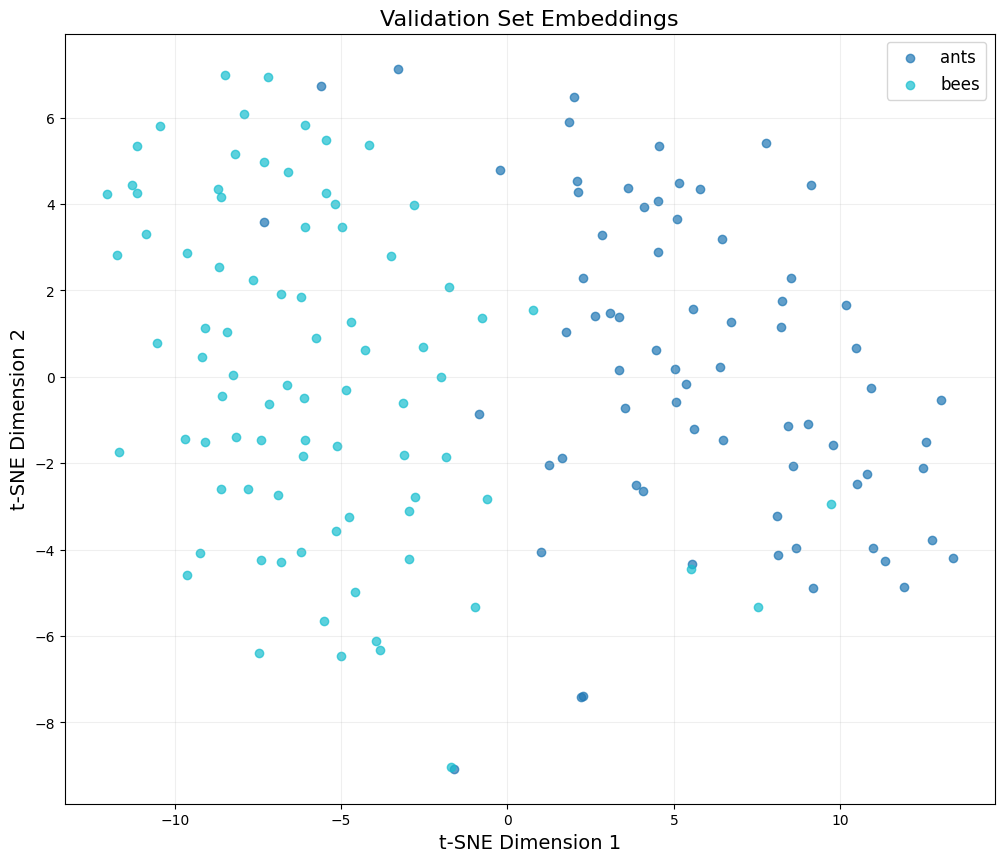


Training SVM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Training Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Model Comparison:
Model          Accuracy  F1 Score  
SVM            0.961     0.961
Random Forest  0.967     0.967


In [47]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle

# 1. Enhanced Feature Extraction with Normalization
def extract_resnet_features(model, dataloader, device):
    """
    Extract and normalize features from ResNet18 model
    """
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Global average pooling and L2 normalization
            if outputs.dim() == 4:  # [batch, channels, h, w]
                outputs = torch.nn.functional.adaptive_avg_pool2d(outputs, (1, 1))
            features.append(outputs.squeeze().cpu().numpy())
            labels.append(targets.numpy())

    features = np.vstack(features)
    labels = np.concatenate(labels)

    # L2 normalization
    features = features / np.linalg.norm(features, axis=1, keepdims=True)

    return features, labels

# 2. Enhanced t-SNE Visualization
def visualize_embeddings(features, labels, class_names, title='t-SNE Visualization'):
    """
    Improved visualization with better formatting
    """
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 10))
    scatter = []
    colors = plt.cm.get_cmap('tab10', len(class_names))

    for i, class_name in enumerate(class_names):
        idx = labels == i
        sc = plt.scatter(features_2d[idx, 0], features_2d[idx, 1],
                        color=colors(i), label=class_name, alpha=0.7)
        scatter.append(sc)

    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=14)
    plt.ylabel('t-SNE Dimension 2', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.2)
    plt.show()

# 3. Model Training with Feature Similarity Tracking
def train_and_evaluate(train_features, train_labels, val_features, val_labels):
    """
    Enhanced training with similarity monitoring
    """
    # Standardize features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)

    # SVM with RBF kernel
    print("\nTraining SVM...")
    svm_params = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.001, 0.01, 0.1]}
    svm = SVC(kernel='rbf', probability=True, random_state=42)
    svm_grid = GridSearchCV(svm, svm_params, cv=5, n_jobs=-1, verbose=1)
    svm_grid.fit(train_features_scaled, train_labels)

    # Random Forest
    print("\nTraining Random Forest...")
    rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
    rf = RandomForestClassifier(random_state=42)
    rf_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, verbose=1)
    rf_grid.fit(train_features, train_labels)

    # Evaluate models
    def evaluate(model, features, labels, scaled=True):
        features = scaler.transform(features) if scaled else features
        pred = model.predict(features)
        acc = accuracy_score(labels, pred)
        f1 = f1_score(labels, pred, average='weighted')
        return acc, f1

    svm_val_acc, svm_val_f1 = evaluate(svm_grid, val_features, val_labels, scaled=True)
    rf_val_acc, rf_val_f1 = evaluate(rf_grid, val_features, val_labels, scaled=False)

    # Print results
    print("\nModel Comparison:")
    print(f"{'Model':<15}{'Accuracy':<10}{'F1 Score':<10}")
    print(f"{'SVM':<15}{svm_val_acc:.3f}{'':<5}{svm_val_f1:.3f}")
    print(f"{'Random Forest':<15}{rf_val_acc:.3f}{'':<5}{rf_val_f1:.3f}")

    return svm_grid.best_estimator_, rf_grid.best_estimator_, scaler

# Main execution
if __name__ == "__main__":
    # Load and prepare model
    model_ft = torch.nn.Sequential(*(list(models.resnet18(pretrained=True).children())[:-1]))
    for param in model_ft.parameters():
        param.requires_grad_(False)
    model_ft = model_ft.to(device)

    # Extract features
    train_features, train_labels = extract_resnet_features(model_ft, dataloaders['train'], device)
    val_features, val_labels = extract_resnet_features(model_ft, dataloaders['val'], device)

    # Visualize embeddings
    visualize_embeddings(train_features, train_labels, class_names, 'Training Set Embeddings')
    visualize_embeddings(val_features, val_labels, class_names, 'Validation Set Embeddings')

    # Train and evaluate models
    svm_model, rf_model, scaler = train_and_evaluate(train_features, train_labels, val_features, val_labels)

    # Save models
    with open('svm_model.pkl', 'wb') as f:
        pickle.dump(svm_model, f)
    with open('rf_model.pkl', 'wb') as f:
        pickle.dump(rf_model, f)
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)